# Unidad 4: Ingeniería de características y selección de modelos

In [1]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## Transformación de variables
### Discretización

In [2]:
import pandas as pd

print(pd.cut(np.array([.2, 1.4, 2.5, 6.2, 9.7, 2.1]), 3,
             labels = ['good', 'medium', 'bad'],
             retbins = True))

([good, good, good, medium, bad, good]
Categories (3, object): [good < medium < bad], array([0.1905    , 3.36666667, 6.53333333, 9.7       ]))


In [3]:
def get_WoE(data, var, target):
    crosstab = pd.crosstab(data[target], data[var])
    
    print("Obteniendo el Woe para la variable", var, ":")
    
    for col in crosstab.columns:
        if crosstab[col][1] == 0:
            print("  El WoE para", col, "[", sum(crosstab[col]), "] es infinito")
        else:
            WoE = np.log(float(crosstab[col][0]) / float(crosstab[col][1]))
            print("  El WoE para", col, "[", sum(crosstab[col]), "] es", WoE)

In [4]:
data = pd.DataFrame({'Value': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                   'Target': [True, True, False, True, True, False, True, False, False, False]})

data['Cat 1'] = data['Value'] > 3
data['Cat 2'] = data['Value'] > 6

get_WoE(data, 'Cat 1', 'Target')
get_WoE(data, 'Cat 2', 'Target')

Obteniendo el Woe para la variable Cat 1 :
  El WoE para False [ 3 ] es -0.6931471805599453
  El WoE para True [ 7 ] es 0.28768207245178085
Obteniendo el Woe para la variable Cat 2 :
  El WoE para False [ 6 ] es -0.6931471805599453
  El WoE para True [ 4 ] es 1.0986122886681098


## Normalización

In [5]:
from sklearn.preprocessing import MinMaxScaler

data = [35.6, -26.4, 54.9, -63.4, 37.9, 45.8, 44.3, 9.2, 35.5, -12.9]
data = np.array(data).reshape(-1, 1)

scaler = MinMaxScaler().fit(data)
scaler.transform(data)

array([[0.83685545],
       [0.31276416],
       [1.        ],
       [0.        ],
       [0.85629755],
       [0.92307692],
       [0.9103973 ],
       [0.613694  ],
       [0.83601014],
       [0.42688081]])

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(data)
scaler.transform(data)

array([[ 0.53347433],
       [-1.15836242],
       [ 1.06012673],
       [-2.16800692],
       [ 0.59623601],
       [ 0.81180876],
       [ 0.77087723],
       [-0.18692067],
       [ 0.53074556],
       [-0.78997861]])

In [7]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(data)
scaler.transform(data)

array([[ 9.98502247e-04],
       [-1.23714428e+00],
       [ 3.86420369e-01],
       [-1.97603595e+00],
       [ 4.69296056e-02],
       [ 2.04692961e-01],
       [ 1.74737893e-01],
       [-5.26210684e-01],
       [-9.98502247e-04],
       [-9.67548677e-01]])

In [8]:
from sklearn.preprocessing import Normalizer

scaler = Normalizer().fit(data)
scaler.transform(data)

array([[ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.]])

## Selección de características
### Selección univariante de características

In [9]:
wine = pd.read_csv('winequality-white.csv', sep = ';')

target = 'quality'
features = list(wine.columns)
features.remove('quality')

x = wine[features]
y = wine[target]

#### Eliminar variables con baja varianza
Esto permite eliminar las variables que no varian suficiente

In [10]:
from sklearn.feature_selection import VarianceThreshold

var_th = VarianceThreshold(threshold = 0.60)
x_var = var_th.fit_transform(x)

print("Variables originales ", x.shape[1])
print("Variables finales ", x_var.shape[1])

print("Listado de variables ", np.asarray(list(x))[var_th.get_support()])

Variables originales  11
Variables finales  5
Listado de variables  ['fixed acidity' 'residual sugar' 'free sulfur dioxide'
 'total sulfur dioxide' 'alcohol']


#### Selección de mejores k 

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression 
from sklearn.feature_selection import chi2 

var_sk = SelectKBest(f_regression, k = 5)
x_sk = var_sk.fit_transform(x, y)

print("Variables finales ", x_sk.shape[1])

print("Listado de variables ", np.asarray(list(x))[var_sk.get_support()])

Variables finales  5
Listado de variables  ['volatile acidity' 'chlorides' 'total sulfur dioxide' 'density' 'alcohol']


In [12]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression 

var_sp = SelectPercentile(f_regression, percentile = 50)
x_sp = var_sp.fit_transform(x, y)

print("Variables finales ", x_sp.shape[1])

print("Listado de variables ", np.asarray(list(x))[var_sp.get_support()])

Variables finales  5
Listado de variables  ['volatile acidity' 'chlorides' 'total sulfur dioxide' 'density' 'alcohol']


#### IV

In [13]:
# Importación de los datos
credit_approval = pd.read_csv('crx_data.txt', sep = ',')
credit_approval.head()
mask = credit_approval.applymap(lambda x: x in ['?'])
credit_not_null = credit_approval[-mask.any(axis=1)]

# Separación de las variables
var_categoricas = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A11', 'A12', 'A13']
var_numericas   = ['A2', 'A3', 'A8', 'A14', 'A15']
var_target      = credit_not_null['A16'] == '+'

In [14]:
result_IV = []

for v_cat in var_categoricas:
    var_target = array(var_target)
    var_values = array(credit_not_null[v_cat])
    var_levels = unique(var_values)

    mat_values = numpy.zeros(shape=(len(var_levels),2))

    for i in range(len(var_target)):
        # Obtención de la posición en los niveles del valor
        for j in range(len(var_levels)):
            if var_levels[j] == var_values[i]:
                pos = j
                break

        # Estimación del número valores en cada nivel
        if var_target[i]:
            mat_values[pos][0] += 1
        else:
            mat_values[pos][1] += 1

        # Obtención del IV
        IV = 0
        for j in range(len(var_levels)):
            if mat_values[j][0] > 0 and mat_values[j][1] > 0:
                rt = mat_values[j][0] / (mat_values[j][0] + mat_values[j][1])
                rf = mat_values[j][1] / (mat_values[j][0] + mat_values[j][1])
                IV += (rt - rf) * np.log(rt / rf)
        
    # Se agrega el IV al listado
    result_IV.append(IV)

for i in range(len(var_categoricas)):
    print("La característica", var_categoricas[i], "el IV es", result_IV[i])

La característica A1 el IV es 0.0310557839281664
La característica A4 el IV es 0.3533127253364721
La característica A5 el IV es 0.3533127253364721
La característica A6 el IV es 5.3014914713397445
La característica A7 el IV es 2.3483934988530426
La característica A9 el IV es 3.247690741686085
La característica A10 el IV es 0.895478013340589
La característica A11 el IV es 11.056999091606574
La característica A12 el IV es 0.04239257914041444
La característica A13 el IV es 0.4114703981527519


### VIF

In [15]:
from sklearn.linear_model import LinearRegression

def calculateVIF(data):
    features = list(data.columns)
    num_features = len(features)
    
    model = LinearRegression()
    
    result = pd.DataFrame(index = ['VIF'], columns = features)
    result = result.fillna(0)
    
    for ite in range(num_features):
        x_features = features[:]
        y_featue = features[ite]
        x_features.remove(y_featue)
        
        x = data[x_features]
        y = data[y_featue]
        
        model.fit(data[x_features], data[y_featue])
        
        result[y_featue] = 1/(1 - model.score(data[x_features], data[y_featue]))
    
    return result

In [16]:
def selectDataUsingVIF(data, max_VIF = 5):
    result = data.copy(deep = True)
    
    VIF = calculateVIF(result)
    
    while VIF.as_matrix().max() > max_VIF:
        col_max = np.where(VIF == VIF.as_matrix().max())[1][0]
        features = list(result.columns)
        features.remove(features[col_max])
        result = result[features]
        
        VIF = calculateVIF(result)
        
    return result

In [17]:
calculateVIF(x.copy(deep = True))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
VIF,2.691435,1.141156,1.165215,12.644064,1.236822,1.78788,2.239233,28.232546,2.196362,1.13854,7.706957


In [18]:
calculateVIF(selectDataUsingVIF(x))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol
VIF,1.356128,1.128298,1.159884,1.435215,1.203645,1.744627,2.15317,1.330912,1.056637,1.647117


### Stepwise

In [19]:
from sklearn.linear_model import LinearRegression

# Modelo para realizar los ajustes
model = LinearRegression()

# Variable para almecena los índices de la lista de atributos usados
feature_order =  []
feature_error = []

# Iteración sobre todas las variables
for i in range(len(features)):
    idx_try = [val for val in range(len(features)) if val not in feature_order]
    iter_error = []

    for i_try in idx_try:
        useRow = feature_order[:]
        useRow.append(i_try)

        use = x[x.columns[useRow]]

        model.fit(use, y)
        rmsError = numpy.linalg.norm((y - model.predict(use)), 2)/sqrt(len(y))
        iter_error.append(rmsError)

    pos_best = numpy.argmin(iter_error)
    feature_order.append(idx_try[pos_best])
    feature_error.append(iter_error[pos_best])

for i in range(len(features)):
    print("En el paso", i, "se ha insertado la variable", 
        features[feature_order[i]], "con un error", feature_error[i])

En el paso 0 se ha insertado la variable alcohol con un error 0.7971284628753887
En el paso 1 se ha insertado la variable volatile acidity con un error 0.7718855628010987
En el paso 2 se ha insertado la variable residual sugar con un error 0.7625355633982083
En el paso 3 se ha insertado la variable free sulfur dioxide con un error 0.75971866818118
En el paso 4 se ha insertado la variable density con un error 0.7571558149343741
En el paso 5 se ha insertado la variable pH con un error 0.7539223820416561
En el paso 6 se ha insertado la variable sulphates con un error 0.7513501300860863
En el paso 7 se ha insertado la variable fixed acidity con un error 0.7504977761870432
En el paso 8 se ha insertado la variable total sulfur dioxide con un error 0.7504542162952706
En el paso 9 se ha insertado la variable chlorides con un error 0.7504400010693044
En el paso 10 se ha insertado la variable citric acid con un error 0.7504359153109991


Text(0,0.5,'Error (RMS)')

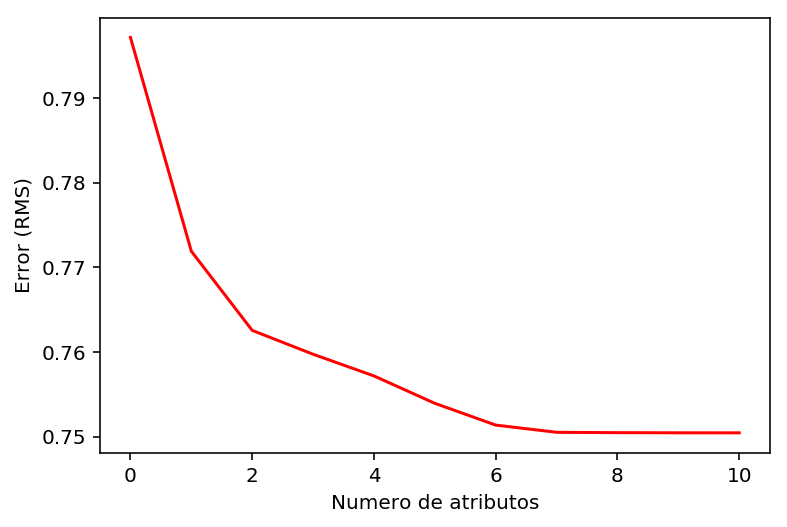

In [20]:
plot(range(len(features)), feature_error, 'r-', label = 'Datos')

xlabel('Numero de atributos')
ylabel('Error (RMS)')

### Ridge Regression

In [21]:
from sklearn.linear_model import Lasso

model_ridge = Lasso(alpha = 0.1)
model_ridge.fit(x, y)

print(model_ridge.coef_)

[-0.         -0.          0.          0.00702328 -0.          0.00808195
 -0.0027108  -0.          0.          0.          0.24638052]


## Selección de modelos

In [22]:
from sklearn.model_selection import GridSearchCV

# Listado de alphas para ser evaluados
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001])

# Creación del modelo
model = Lasso()

# Selección del modelo
grid = GridSearchCV(estimator = model,
                    param_grid = dict(alpha = alphas),
                    cv = 10)
grid.fit(x, y)

# Los mejores parametros para el modelo
print('El mejor parametro es', grid.best_params_)
print('El mejor score es', grid.best_score_)

El mejor parametro es {'alpha': 0.001}
El mejor score es 0.2436570250206135


In [23]:
fit_intercept = np.array([True, False])

# Selección del modelo
grid = GridSearchCV(estimator = model,
                    param_grid = dict(alpha = alphas,
                                      fit_intercept = fit_intercept),
                    cv = 10)
grid.fit(x, y)

# Los mejores parametros para el modelo
print('El mejor parametro es', grid.best_params_)
print('El mejor score es', grid.best_score_)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

El mejor parametro es {'alpha': 0.001, 'fit_intercept': True}
El mejor score es 0.24365702502061357


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [25]:
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

param_grid = dict(alpha = sp_rand())

rsearch = RandomizedSearchCV(estimator = model,
                             param_distributions = param_grid,
                             n_iter = 100,
                             cv = 10,
                             random_state = 1)
rsearch.fit(x, y)

# Los mejores parametros para el modelo
print('El mejor parametro es', rsearch.best_params_)
print('El mejor score es', rsearch.best_score_)

El mejor parametro es {'alpha': 0.00011437481734488664}
El mejor score es 0.24362091713465736
